In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
# loading crime data
crime = pd.read_csv("out.moreno_crime_crime", delim_whitespace=True, header=None, skiprows=[0,1],
                   names=['Person', 'Crime'])
# loading relationship data
crime['Relationship'] = pd.read_csv("rel.moreno_crime_crime.person.role", header=None)

crime.head()

,Person,Crime,Relationship
0,1,1,Suspect
1,1,2,Victim
2,1,3,Victim
3,1,4,Suspect
4,2,5,Victim


In [3]:
# Total number of people
len(crime.Person.unique())

829

In [4]:
# Total number of crimes
len(crime.Crime.unique())

551

In [5]:
# Count of how many crimes each person was involved in 
crime.Person.value_counts().head()

815    25
2      22
425    18
220    17
56     14
Name: Person, dtype: int64

In [6]:
# adding count 
crime['Count'] = crime.groupby(['Person'])['Crime'].transform('count')
crime.head()

,Person,Crime,Relationship,Count
0,1,1,Suspect,4
1,1,2,Victim,4
2,1,3,Victim,4
3,1,4,Suspect,4
4,2,5,Victim,22


In [7]:
# loading name data
names = pd.read_csv("ent.moreno_crime_crime.person.name", sep='\t', header=None)

# loading sex data
names['Sex'] = pd.read_csv("ent.moreno_crime_crime.person.sex", header=None)
names.ix[names.Sex == 1, 'Sex'] = 'M'
names.ix[names.Sex == 0, 'Sex'] = 'F'

# replacing left nodes (people involved in a crime) with names and adding sex
# Right nodes stay as numbers to identify as crimes, not people
for i in range(0,len(names)):
    crime.ix[crime.Person == i+1, 'Sex'] = names.iloc[i][1]
    crime.ix[crime.Person == i+1, 'Person'] = names.iloc[i][0]
    
crime.head()

,Person,Crime,Relationship,Count,Sex
0,AbelDennis,1,Suspect,4,M
1,AbelDennis,2,Victim,4,M
2,AbelDennis,3,Victim,4,M
3,AbelDennis,4,Suspect,4,M
4,AbramsChad,5,Victim,22,M


In [8]:
# Create graph
G = nx.Graph()
G = nx.from_pandas_dataframe(crime, 'Person', 'Crime', ['Relationship', 'Count', 'Sex'])

# a bit of info about the graph
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391


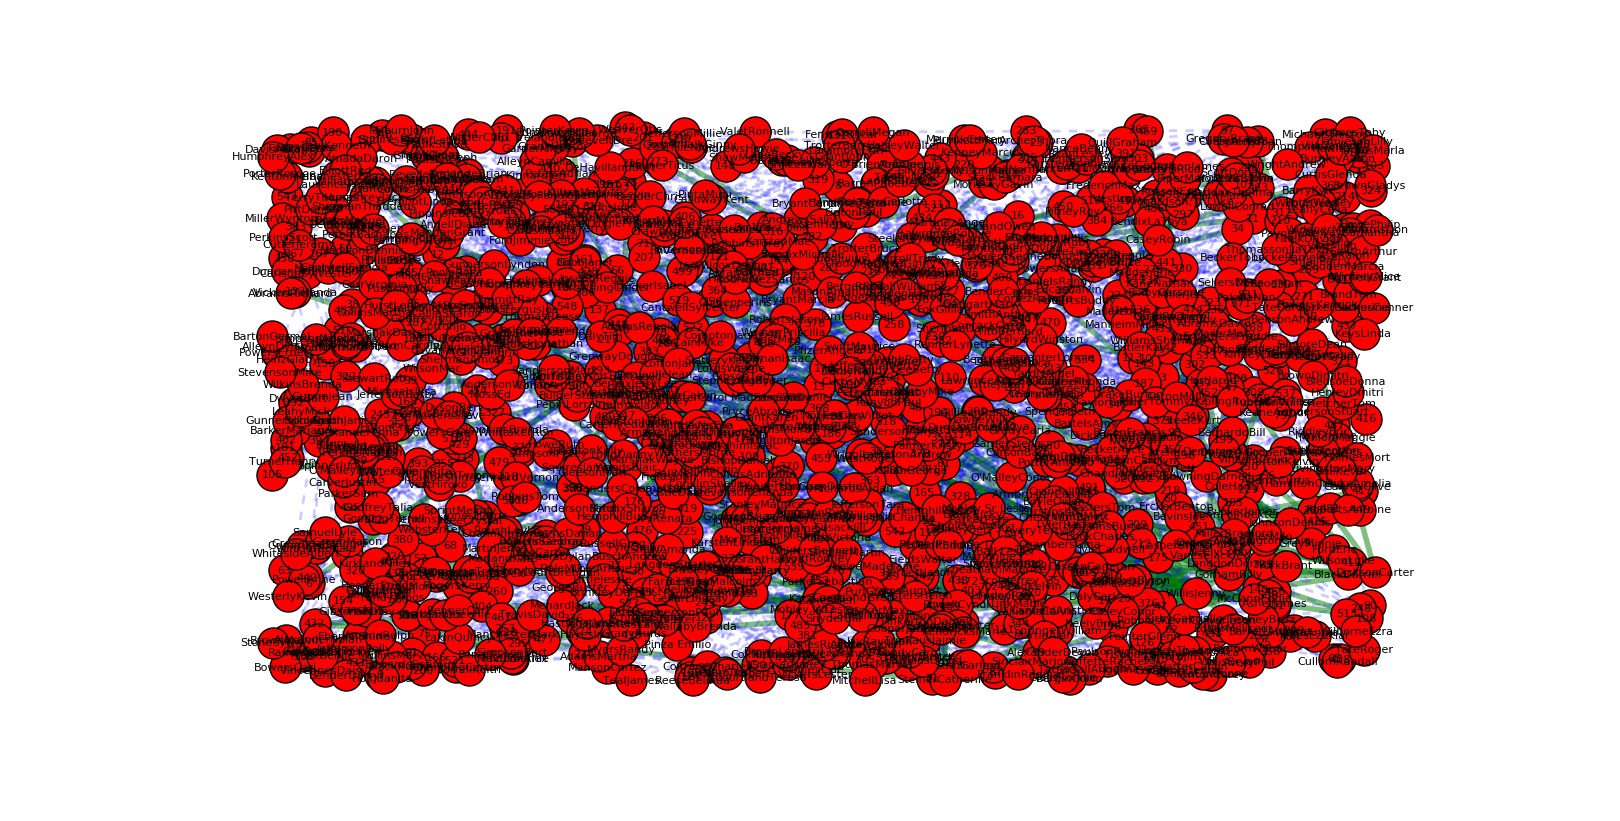

In [9]:
## plot the overall network
pos=nx.random_layout(G) # positions for all nodes

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] > 10]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] <= 10]

# nodes
nx.draw_networkx_nodes(G,pos,node_size=500)
# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='g',style='solid')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [10]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)

# Degree centrality
deg_cen = nx.degree_centrality(G)

# Closeness centrality
clo_cen = nx.closeness_centrality(G)

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(G)

## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])